# 1. Install the necessary packages

In [ ]:
# !pip install gym==0.15.3
# !pip install atari-py
# !pip install matplotlib
# !pip install tqdm
# !pip install tensorflow

# 2. Install the Atari library

"Pong" refers to Atari games, so download the library with Atari games from the official website and install it. One of the options for how to do this is presented in the cell below.

In [ ]:
# import urllib.request
# urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
# !pip install unrar
# !unrar x Roms.rar
# !mkdir rars
# !mv 'HC ROMS' rars
# !mv ROMS rars
# !python -m atari_py.import_roms rars

# 3. Importing the necessary libraries

In [1]:
import numpy as np
import time
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import random
from tqdm.notebook import tqdm, trange
from gym.wrappers import Monitor
from keras.models import load_model
import pickle

import gym

import tensorflow as tf
print(gym.__version__)

2023-02-02 01:53:48.612854: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0.15.3


# 4. Importing the environment with the game "Pong-v0"

In [2]:
env = gym.make("Pong-v0")

STATE_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
ACTION_MEANING = env.unwrapped.get_action_meanings()

print('States shape: {}'.format(STATE_SHAPE))
print('Actions: {}'.format(NUM_ACTIONS))
print('Actions: {}'.format(ACTION_MEANING))

States shape: (210, 160, 3)
Actions: 6
Actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


As we can see, each state of the environment is represented by a color picture (3 color channels) with a size of 210 x 160. The agent can perform 6 actions.

# 5. Let's write a function to encode the current state of our environment into an embedding array.

In [3]:
def rgb2embedding(rgb): # rgb - the state of the environment (image in the form of an array 210x160x3)
    
    # Convert the image from color to gray and normalize the pixel brightness values to a range from 0 to 1.
    rgb = rgb / 255.
    result = []
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b # gray - an array of dimension 210x160
    
    # !IMPORTANT! 
    # For an explanation of the further progress of this function, see the file README.md from the repository
    gray = gray[34:194] # gray - an array of dimension 160x160
   
    racket2 = np.where((gray > 0.577) & (gray < 0.578)) # The brightness value of the right racket is 0.57713255
    if len(racket2[0]) == 0:
        result.extend([-1, -1, -1, -1])
    else:
        result.extend([racket2[0][0], racket2[1][0], racket2[0][-1], racket2[1][-1]])
    ball = np.where((gray > 0.925) & (gray < 0.926)) # The brightness value of the ball is 0.92539765
    if len(ball[0]) == 0:
        result.extend([-1, -1, -1, -1])
    else:
        result.extend([ball[0][0], ball[1][0], ball[0][-1], ball[1][-1]])
    result = np.array(result)[np.newaxis, ...] # result - an array of dimension 1x8
    return result / 160

# 6. Let's set hyperparameters.

In [4]:
lr = 2.5e-4 # learning rate
gamma = 0.99 # discount parameter

NUM_EPISODES = 100000 # number of training episodes

REWARD_AVERAGE_WINDOW = 100 # window for averaging awards by episode

REPLAY_BUFFER = 50000 # buffer size for storing sars chains
MIN_REPLAY_BUFFER = 10000 # the minimum size of the buffer, after which random chains will be taken from it for training
BATCH_SIZE = 32 # the size of the training batch
FIT_FREQ = 4 # frequency of training
COPY_PERIOD = 10000 # the period of copying the weights of the model from the current to the target

RNN_LENGTH = 4 # length of the recurrent chain

# 7. Let's write down the function that creates the architecture of our model.

In [ ]:
def make_model(emb_size):
    model = tf.keras.Sequential()
    # the first layer is recurrent. It takes into account the dynamics of the ball movement
    model.add(tf.keras.layers.SimpleRNN(emb_size * 8, activation='relu', return_sequences=False, input_shape=(None, emb_size)))
    model.add(tf.keras.layers.Dense(emb_size * 4, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation = 'relu'))
    model.add(tf.keras.layers.Dense(emb_size * 2, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.), activation = 'relu'))
    model.add(tf.keras.layers.Dense(NUM_ACTIONS, kernel_initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='mse', optimizer=optimizer)
    return model
# let's create two models of the same architecture, but with different randomly initialized weights
model = make_model(8)
target_model = make_model(8)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4672      
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
Total params: 7,382
Trainable params: 7,382
Non-trainable params: 0
_________________________________________________________________


# 8. Let's make the weights of our two created networks the same.

In [ ]:
def copy_network(model1, model2):
    frm = model1
    to = model2
    for l_tg,l_sr in zip(to.layers,frm.layers):
        wk = l_sr.get_weights()
        l_tg.set_weights(wk)
   
copy_network(model, target_model)

# 9. Initialize the zero initial values of the lists and the counter variable.

## 9.1 First initialization.

Now the code in this paragraph is commented out. But when you start training for the first time, you need to uncomment and execute it. Since the training goes on for a very long time, and the computer can suddenly stop working for various reasons (for example, the lights are turned off), in order not to lose progress, our training saves these five parameters, as well as the model and its weights, every 100 iterations of our training. So if the work was interrupted, then to restore the training from the last checkpoint, we will already comment out paragraph 9.2, and this paragraph (9.1), on the contrary, we will comment out and will not refer to it again in the future.

In [ ]:
pathLenList = [] # trajectory lengths by episodes
totalRewardList = [] # total awards by episodes
totalRewardAverageList = [] # total awards by episodes (window average)
sars_list = [] # a list of sars chains, which, when reaching a length equal to "REPLAY_BUFFER",
               # starts deleting the oldest chain when adding a new one
count = 0 # end-to-end iteration counter

## 9.2 Initialization of the saved parameters and the model when resuming work from the checkpoint. 

Here, instead of 99900, it is necessary to substitute the number of the last saved episode in the process of resuming training.

In [15]:
# with open("pathLenList - 99900.txt", "rb") as myFile:
#     pathLenList = pickle.load(myFile)
# with open("totalRewardList - 99900.txt", "rb") as myFile:
#     totalRewardList = pickle.load(myFile)
# with open("totalRewardAverageList - 99900.txt", "rb") as myFile:
#     totalRewardAverageList = pickle.load(myFile)
# with open("values - 99900.txt", "rb") as myFile:
#     count = pickle.load(myFile)
# count = count[0]    
# with open("sars_list - 99900.txt", "rb") as myFile:
#     sars_list = pickle.load(myFile)
# model = load_model('PONG5_model - 99900.h5')

# 10. Finally we begin the learning process

In case of resuming training from a checkpoint, instead of "for i in tqdm(range(NUM_EPISODES)):", write "for i in tqdm(range(99901, NUM_EPISODES)):". Here, instead of 99901, it is necessary to substitute the number of the last saved episode in the process of resuming training + 1.

In [ ]:
from pathlib import Path
import os
path = Path(os.getcwd())

for i in tqdm(range(NUM_EPISODES)): # or "for i in tqdm(range(99901, NUM_EPISODES)):" for example
    eps = 1.0 - i / NUM_EPISODES
    s = env.reset()
    a = env.action_space.sample()
    s, _, done, _ = env.step(a)
    s_emb_batch = rgb2embedding(s)
    totalReward = 0
    step = 0
    total_err = 0
    err_count = 0
    
    while not done:
        count += 1
        step += 1
        if len(s_emb_batch) < RNN_LENGTH:
            a = env.action_space.sample()
        else:
            if np.random.rand() < eps:
                a = env.action_space.sample()
            else:
                Q_s = model(s_emb_batch[np.newaxis, ...]).numpy()
                a = np.argmax(Q_s)
        s1, r, done, _ = env.step(a)
        s_emb1 = rgb2embedding(s1)
        s_emb_batch_old = s_emb_batch.copy()
        s_emb_batch = np.vstack((s_emb_batch, s_emb1))
        if len(s_emb_batch) > RNN_LENGTH:
            s_emb_batch = np.delete(s_emb_batch, (0), axis=0)
        if len(s_emb_batch_old) == RNN_LENGTH:
            sars_list.append([s_emb_batch_old, a, r, s_emb_batch, done])
        if len(sars_list) > REPLAY_BUFFER:
            del sars_list[0]
        if count % FIT_FREQ == 0 and count >= FIT_FREQ and len(sars_list) != 0:
            if len(sars_list) >= MIN_REPLAY_BUFFER:
                batch_s, actions, rewards, batch_s1, terminal = map(np.array,zip(*random.sample(sars_list,BATCH_SIZE)))
                next_state_action_values = np.max(target_model.predict(batch_s1),axis=1)
                targets = model.predict(batch_s)
                targets[range(BATCH_SIZE), actions] = rewards + gamma*next_state_action_values*np.invert(terminal)
                err = model.train_on_batch(batch_s, targets)
                total_err += err
                err_count += 1
        if count % COPY_PERIOD == 0:
            print('Copy weights')
            copy_network(model, target_model)
        totalReward += r        
    print("Episode total reward:", totalReward)
    if err_count != 0:
        print('Mean total error: ', total_err / err_count)
    if i%100 == 0:
        print("Saving the model")
        weights_to_save = f"PONG5_weights - {i}.h5"
        path_to_save = str(path / weights_to_save)
        model.save_weights(path_to_save)
        model_to_save = f"PONG5_model - {i}.h5"
        path_to_save = str(path / model_to_save)
        model.save(path_to_save)
    print(f'Эпизод закончен за {step} шагов')                
    pathLenList.append(step)
    totalRewardList.append(totalReward)
    
    if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
        totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
        totalRewardAverageList.append(totalRewardAverage)
        print('Episode {}: average total reward = {}'.format(i, totalRewardAverage))
    if i%100 == 0 and i > 0:
        with open(f"pathLenList - {i}.txt", "wb") as myFile:
            pickle.dump(pathLenList, myFile)
        with open(f"totalRewardList - {i}.txt", "wb") as myFile:
            pickle.dump(totalRewardList, myFile)
        with open(f"totalRewardAverageList - {i}.txt", "wb") as myFile:
            pickle.dump(totalRewardAverageList, myFile)
        with open(f"values - {i}.txt", "wb") as myFile:
            pickle.dump([count], myFile)
        with open(f"sars_list - {i}.txt", "wb") as myFile:
            pickle.dump(sars_list, myFile)

# 11. We save the model and weights in different formats to the "Finish_model" folder.

In [ ]:
model.save('Finish_Model/MODEL_H5.h5')
model.save('Finish_Model/MODEL')
model.save_weights('Finish_Model/WEIGHTS_H5.h5')
model.save_weights('Finish_Model/WEIGHTS')

Next, to load the finished model, you just need to run the command:

In [14]:
# model = load_model('Finish_Model/MODEL')

# 12. Various statistics and an example of the game of the finished model.

## 12.1 A graph of the duration of episodes. 

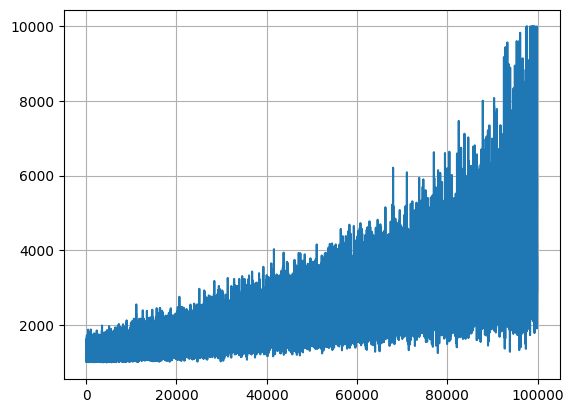

In [17]:
plt.plot(pathLenList)
plt.grid()

As we can see, the duration of episodes increases. This suggests that the network is playing better and the game is no longer going "one-way".

## 12.2  A graph of total awards by episode.

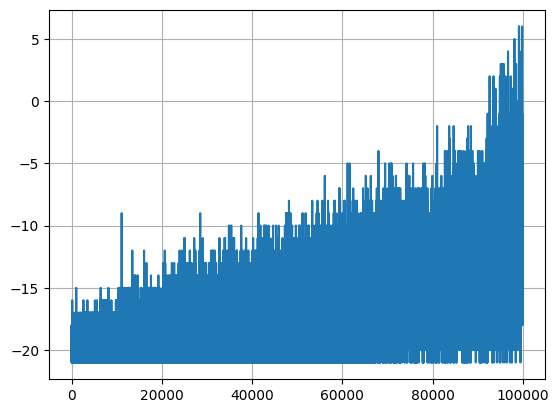

In [22]:
plt.plot(totalRewardList)
plt.grid()

As we can see, even 100,000 episodes for learning how to win all the games were not enough. Indeed, there are quite a lot of all possible trajectories. Again, it was still possible to experiment with hyperparameters, as I said above. But the dynamics are clearly visible.

## 12.3  A graph of the awards averaged for every 100 episodes.

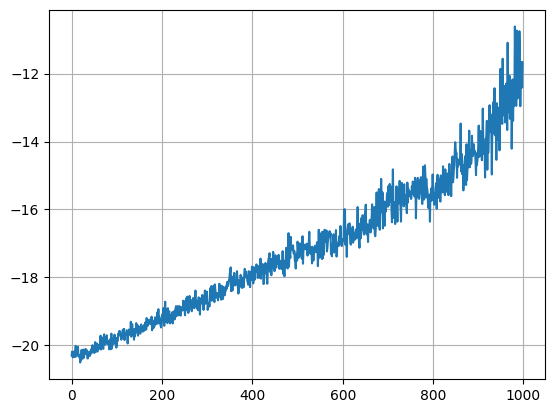

In [24]:
plt.plot(totalRewardAverageList)
plt.grid()

Similar to the previous schedule. The dynamics are also clearly visible.

## 12.4 An example of a game of a ready-made model. 

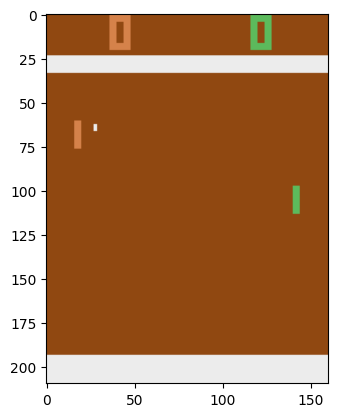

KeyboardInterrupt: 

In [27]:
s = env.reset()
s_emb_batch = rgb2embedding(s)
totalReward = 0
step = 0

while True:
    _=plt.imshow(s)
    plt.show()
    time.sleep(0.5)
    display.clear_output(wait=True)
    step += 1
    if len(s_emb_batch) < RNN_LENGTH:
        a = env.action_space.sample()
    else:
        Q_s = model(s_emb_batch[np.newaxis, ...]).numpy()
        a = np.argmax(Q_s)
    s, r, done, _ = env.step(a)
    totalReward += r
    s_emb = rgb2embedding(s)
    s_emb_batch = np.vstack((s_emb_batch, s_emb))
    if len(s_emb_batch) > RNN_LENGTH:
        s_emb_batch = np.delete(s_emb_batch, (0), axis=0)
    if r != 0:
        print('New reward = {}'.format(r))
    if done:        
        break
print('Total reward = {}'.format(totalReward))